# Multivariate Analysis of StackOverflow Corpus  

# Imports

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy.cluster.hierarchy import dendrogram, ward, linkage
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from yellowbrick.text import TSNEVisualizer

%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [63]:
# Set Global Variables & Remove Matplotlib warnings
RANDOM_SEED = 86
matplotlib_axes_logger.setLevel("ERROR")

In [160]:
# Import corpus & vectorized representations
cleaned_corpus_df = pd.read_csv("data/cleaned_corpus.csv")
word_vec_df = pd.read_csv("data/count_term_doc_matrix.csv")
tfidf_df = pd.read_csv("data/tfidf_term_doc_matrix.csv")
embd_100_df = pd.read_csv("data/embeddings_100_dim.csv")
embd_50_df = pd.read_csv("data/embeddings_50_dim.csv")

In [138]:
# Review imports
print(word_vec_df.shape)
print(tfidf_df.shape)
print(embd_100_df.shape)
print(embd_50_df.shape)

(919, 5001)
(919, 5001)
(919, 101)
(919, 51)


In [45]:
# Set labels
y_labels = cleaned_corpus_df["so_tag"]

### Transpose Count & TF-IDF Vectorized Dataframe  
These will be used to visualize clusters of words instead of documents. The loaded embeddings and vectorized corpus files are organized as document by term matrices.

In [139]:
# Transpose data frame --> Words as rows, documents as columns
wvT = word_vec_df.T
tfidfT = tfidf_df.T

# t-SNE (Documents)  
Visualizations of corpus utilizing t-distributed stochastic neighbor embeddings (t-SNE). The `yellowbrick` library has a handy visualizer for t-SNE. In the yellowbrick method, dimensionality reduction is performed first with singular value decomposition (SVD) down to a default 50 dimensions prior to the application of the t-SNE algorithm. This is used to speed up the process. Each point in the plot represents a document in the corpus.  

### Word Count Vectorized Corpus

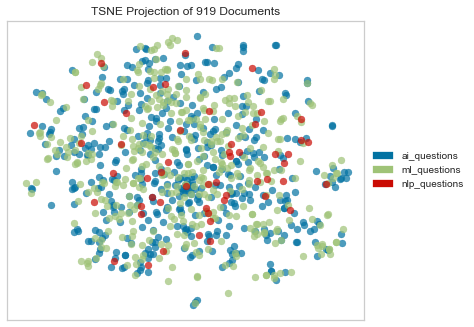

In [67]:
tsne_wv = TSNEVisualizer(random_state=RANDOM_SEED)
tsne_wv.fit(word_vec_df.iloc[:, 1:], cleaned_corpus_df["so_tag"])
tsne_wv.show()

### TF-IDF Vectorized Corpus

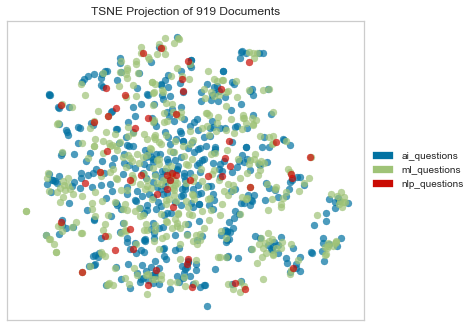

In [68]:
tsne_tfidf = TSNEVisualizer(random_state=RANDOM_SEED)
tsne_tfidf.fit(tfidf_df.iloc[:, 1:], cleaned_corpus_df["so_tag"])
tsne_tfidf.show()

### Doc2Vec Embeddings  

#### 50 Dimension Embeddings

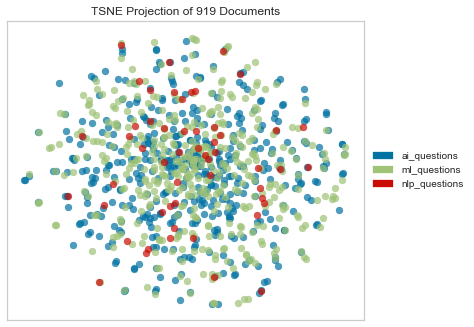

In [70]:
tsne_50embd = TSNEVisualizer(decompose_by=40, random_state=RANDOM_SEED)
tsne_50embd.fit(embd_50_df.iloc[:, 1:], cleaned_corpus_df["so_tag"])
tsne_50embd.show()

#### 100 Dimension Embeddings

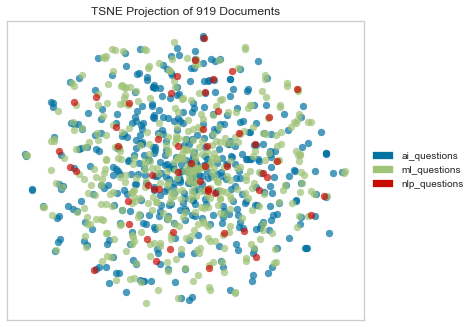

In [71]:
tsne_100embd = TSNEVisualizer(random_state=RANDOM_SEED)
tsne_100embd.fit(embd_100_df.iloc[:, 1:], cleaned_corpus_df["so_tag"])
tsne_100embd.show()

# K-Means Clustering  

### TF-IDF (Special Case)  
I came upon a method while reading the yellowbrick documentation that performs K-means clustering on your data set, then applies the cluster labels to the embeddings generated from t-SNE (instead of the document labels used above). I thought it was interesting so I included it. It appears to cluster the documents in a way that looks more meaningful than the seeminly random clustering of t-SNE on its own.

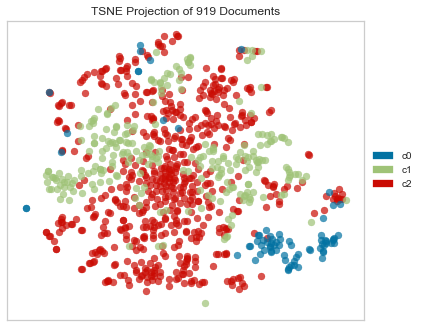

In [82]:
# K-means clustering on document by term matrix
clusters_tfidf = KMeans(n_clusters=3, random_state=RANDOM_SEED)
clusters_tfidf.fit(tfidf_df.iloc[:, 1:])

# t-SNE with cluster labels
tsne_tfidf_km = TSNEVisualizer(random_state=RANDOM_SEED)
tsne_tfidf_km.fit(tfidf_df.iloc[:, 1:], ["c{}".format(c) for c in clusters.labels_])
tsne_tfidf_km.show()

### TF-IDF

In [86]:
cl_tfidf_labels = ["cluster_{}".format(c) for c in clusters_tfidf.labels_]
len(cl_tfidf_labels)

919

In [120]:
# Add cluster labels to df
tfidf_df["kMean_cluster"] = cl_tfidf_labels

# Create filter lists to see documents
cl_0 = tfidf_df.loc[tfidf_df.kMean_cluster == "cluster_0"]["doc_id"].tolist()
cl_1 = tfidf_df.loc[tfidf_df.kMean_cluster == "cluster_1"]["doc_id"].tolist()
cl_2 = tfidf_df.loc[tfidf_df.kMean_cluster == "cluster_2"]["doc_id"].tolist()

#### First Cluster

In [124]:
# Sample Docs
cleaned_corpus_df.loc[cleaned_corpus_df.doc_id.isin(cl_0)][
    ["so_tag", "title", "question"]
].head()

,so_tag,title,question
22,ai_questions,Neural Network example in .NET [closed],Any good tutorial with source that will demons...
27,ai_questions,How to convert the output of an artificial neu...,I've read about neural network a little while ...
69,ai_questions,How to code an artificial neural network (Tic-...,I want to play Tic-tac-toe using an artificial...
73,ai_questions,Convolutional Neural Networks - Multiple Channels,How is the convolution operation carried out w...
85,ai_questions,How to train a neural network to supervised da...,I have played around a bit with pybrain and un...


In [126]:
# StackOverflow tag breakdown
cleaned_corpus_df.loc[cleaned_corpus_df.doc_id.isin(cl_0)].groupby(["so_tag"]).agg(
    doc_count=pd.NamedAgg("doc_id", "count")
)

,doc_count
so_tag,
ai_questions,42
ml_questions,33


#### Second Cluster

In [122]:
# Sample Docs
cleaned_corpus_df.loc[cleaned_corpus_df.doc_id.isin(cl_1)][
    ["so_tag", "title", "question"]
].head()

,so_tag,title,question
15,ai_questions,How do Markov Chain Chatbots work?,I was thinking of creating a chatbot using som...
35,ai_questions,is there any way to import a json file(contain...,Is there any way to import a JSON file (contai...
100,ai_questions,Pseudocode interpreter?,"Like lots of you guys on SO, I often write in ..."
136,ai_questions,Support Vector Machine or Artificial Neural Ne...,We need to decide between Support Vector Machi...
280,ai_questions,Determine context/meaning of a web page (or pa...,Of course Google has been doing this for years...


In [127]:
# StackOverflow tag breakdown
cleaned_corpus_df.loc[cleaned_corpus_df.doc_id.isin(cl_1)].groupby(["so_tag"]).agg(
    doc_count=pd.NamedAgg("doc_id", "count")
)

,doc_count
so_tag,
ai_questions,7
ml_questions,14
nlp_questions,229


#### Third Cluster

In [123]:
# Sample Docs
cleaned_corpus_df.loc[cleaned_corpus_df.doc_id.isin(cl_2)][
    ["so_tag", "title", "question"]
].head()

,so_tag,title,question
0,ai_questions,What is the optimal algorithm for the game 2048?,I have recently stumbled upon the game 2048. Y...
1,ai_questions,Pacman: how do the eyes find their way back to...,I found a lot of references to the AI of the g...
2,ai_questions,What is the best Battleship AI?,"Battleship! Back in 2003 (when I was 17), I co..."
3,ai_questions,source of historical stock data [closed],I'm trying to make a stock market simulator (p...
4,ai_questions,What are good examples of genetic algorithms/g...,Genetic algorithms (GA) and genetic programmin...


In [128]:
# StackOverflow tag breakdown
cleaned_corpus_df.loc[cleaned_corpus_df.doc_id.isin(cl_2)].groupby(["so_tag"]).agg(
    doc_count=pd.NamedAgg("doc_id", "count")
)

,doc_count
so_tag,
ai_questions,251
ml_questions,255
nlp_questions,88


#### Hierarchical Clustering  
I limited the dendrogram to the first 200 rows of the TF-IDF data frame so that it would be somewhat legible.

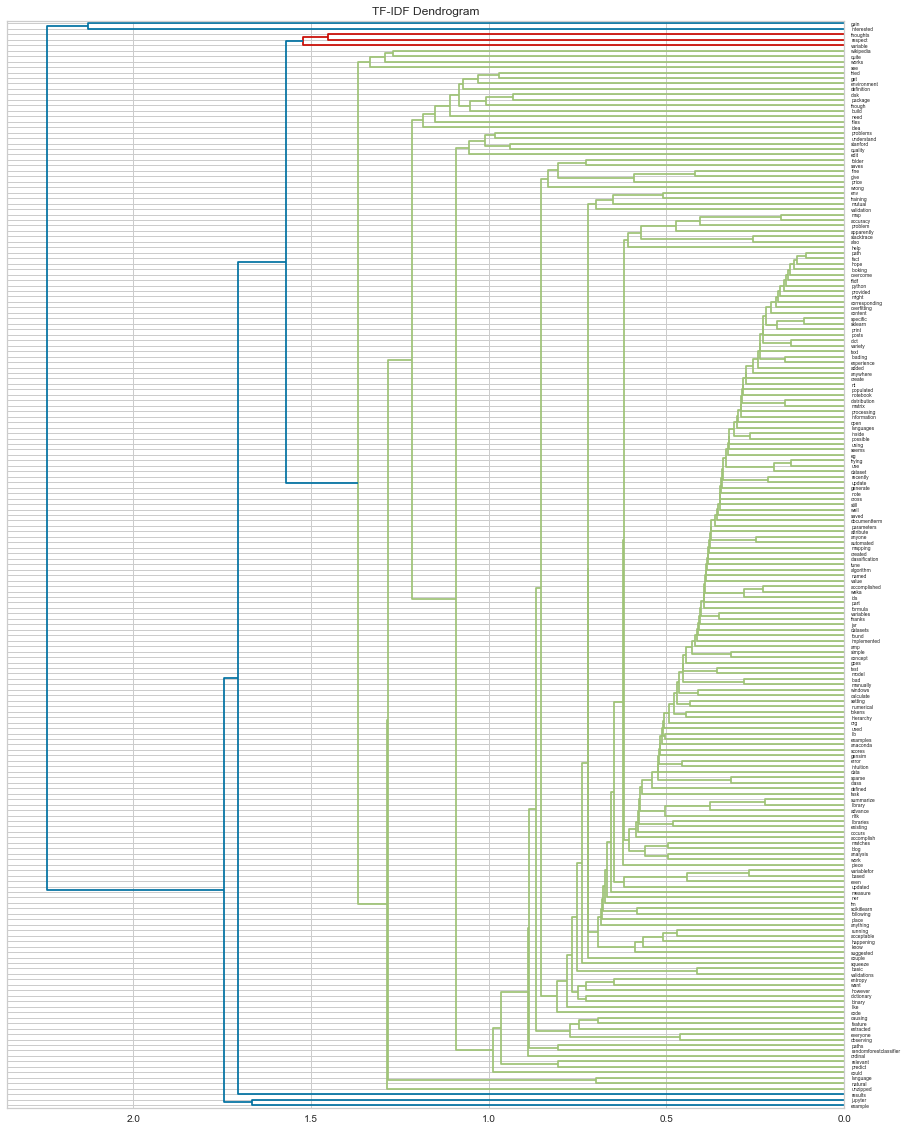

In [178]:
plt.figure(figsize=(15, 20))
plt.title("TF-IDF Dendrogram")
dend = dendrogram(
    linkage(tfidfT.iloc[1:200, :].values, method="ward"),
    orientation="left",
    labels=tfidfT.index[1:200],
)
plt.savefig("imgs/tfidf_dendrogram.png")

### Count Vectorized Matrix

In [180]:
# K-means clustering on document by term matrix
clusters_wv = KMeans(n_clusters=3, random_state=RANDOM_SEED)
clusters_wv.fit(word_vec_df.iloc[:, 1:])

wv_labels = ["cluster_{}".format(c) for c in clusters_wv.labels_]
len(wv_labels)

919

In [182]:
# Add cluster labels to df
word_vec_df["kMean_cluster"] = wv_labels

# Create filter lists to see documents
wv_0 = word_vec_df.loc[word_vec_df.kMean_cluster == "cluster_0"]["doc_id"].tolist()
wv_1 = word_vec_df.loc[word_vec_df.kMean_cluster == "cluster_1"]["doc_id"].tolist()
wv_2 = word_vec_df.loc[word_vec_df.kMean_cluster == "cluster_2"]["doc_id"].tolist()

#### First Cluster

In [183]:
# Sample Docs
cleaned_corpus_df.loc[cleaned_corpus_df.doc_id.isin(wv_0)][
    ["so_tag", "title", "question"]
].head()

,so_tag,title,question
533,ml_questions,Understanding Neural Network Backpropagation,Update: a better formulation of the issue. I'm...
584,ml_questions,Deep Belief Networks vs Convolutional Neural N...,I am new to the field of neural networks and I...
748,ml_questions,How does one train multiple models in a single...,Say I have access to a number of GPUs in a sin...
750,ml_questions,"Building a mutlivariate, multi-task LSTM with ...",Preamble I am currently working on a Machine L...
795,ml_questions,Implementing sparse connections in neural netw...,Some use cases for neural networks requires th...


In [184]:
# StackOverflow tag breakdown
cleaned_corpus_df.loc[cleaned_corpus_df.doc_id.isin(wv_0)].groupby(["so_tag"]).agg(
    doc_count=pd.NamedAgg("doc_id", "count")
)

,doc_count
so_tag,
ml_questions,5
nlp_questions,1


#### Second Cluster

In [185]:
# Sample Docs
cleaned_corpus_df.loc[cleaned_corpus_df.doc_id.isin(wv_1)][
    ["so_tag", "title", "question"]
].head()

,so_tag,title,question
0,ai_questions,What is the optimal algorithm for the game 2048?,I have recently stumbled upon the game 2048. Y...
1,ai_questions,Pacman: how do the eyes find their way back to...,I found a lot of references to the AI of the g...
2,ai_questions,What is the best Battleship AI?,"Battleship! Back in 2003 (when I was 17), I co..."
3,ai_questions,source of historical stock data [closed],I'm trying to make a stock market simulator (p...
4,ai_questions,What are good examples of genetic algorithms/g...,Genetic algorithms (GA) and genetic programmin...


In [186]:
# StackOverflow tag breakdown
cleaned_corpus_df.loc[cleaned_corpus_df.doc_id.isin(wv_1)].groupby(["so_tag"]).agg(
    doc_count=pd.NamedAgg("doc_id", "count")
)

,doc_count
so_tag,
ai_questions,290
ml_questions,284
nlp_questions,314


#### Third Cluster

In [187]:
# Sample Docs
cleaned_corpus_df.loc[cleaned_corpus_df.doc_id.isin(wv_2)][
    ["so_tag", "title", "question"]
].head()

,so_tag,title,question
26,ai_questions,"Markov Decision Process: value iteration, how ...",I've been reading a lot about Markov Decision ...
34,ai_questions,AI of spaceship's propulsion: land a 3D ship a...,This is a very difficult problem about how to ...
104,ai_questions,Trouble Understanding the Backpropagation Algo...,I'm having trouble understanding the backpropa...
177,ai_questions,Neural Network Back-Propagation Algorithm Gets...,Overview So I'm trying to get a grasp on the m...
207,ai_questions,A.I.: How would I train a Neural Network acros...,"So, for larger networks with large data sets, ..."


In [188]:
# StackOverflow tag breakdown
cleaned_corpus_df.loc[cleaned_corpus_df.doc_id.isin(wv_2)].groupby(["so_tag"]).agg(
    doc_count=pd.NamedAgg("doc_id", "count")
)

,doc_count
so_tag,
ai_questions,10
ml_questions,13
nlp_questions,2


#### Hierarchical Clustering  
I limited the dendrogram to the first 200 rows of the data frame so that it would be somewhat legible.

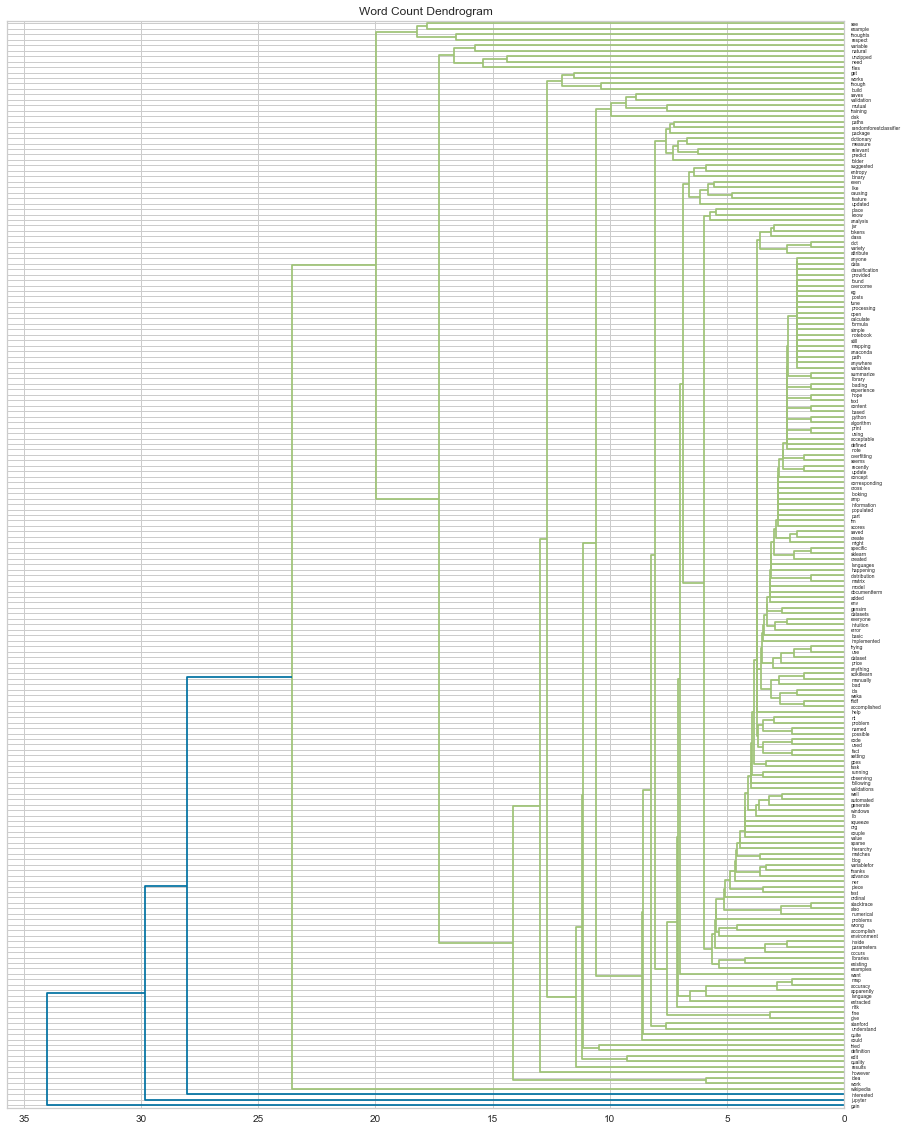

In [189]:
plt.figure(figsize=(15, 20))
plt.title("Word Count Dendrogram")
dend = dendrogram(
    linkage(wvT.iloc[1:200, :].values, method="ward"),
    orientation="left",
    labels=wvT.index[1:200],
)
plt.savefig("imgs/word_count_dendrogram.png")

# t-SNE (Words)  

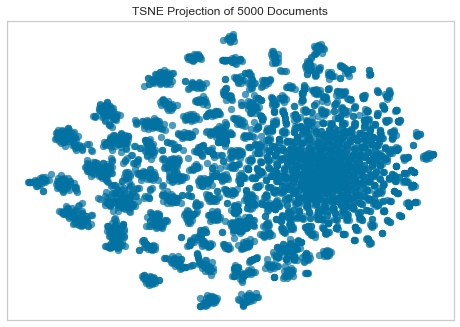

In [190]:
tsne_wv = TSNEVisualizer(random_state=RANDOM_SEED)
tsne_wv.fit(wvT.iloc[1:, :])
tsne_wv.show()

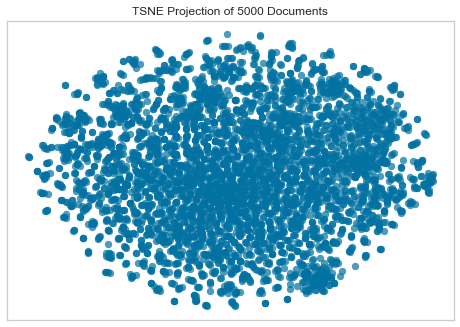

In [193]:
tsne_wv = TSNEVisualizer(random_state=RANDOM_SEED)
tsne_wv.fit(tfidfT.iloc[1:, :])
tsne_wv.show()